# Training an Object Detection Model

## 🌟 Overview
In this tutorial we'll go through the process of training a custom object detection model. We'll first create a dataset, setup the training configuration and then use it to train our own NN model. We'll also validate the performance of our model, export it and make it ready for a deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️-installation)
- [🗃️ Data Preparation](#️-data-preparation)
    - [🧐 Generating Object Detection Annotation](#-generating-object-detection-annotation)
    - [💾 LuxonisDataset](#-luxonisdataset)
- [🏋️‍♂️ Training](#️️-training)
    - [⚙️ Configuration](#️-configuration)
    - [🦾 Train](#-train)
- [✍ Test](#-test)
    - [🧠 Infer](#-infer)
- [🗂️ Export and Archive](#️-export-and-archive)
- [🤖 Deploy](#-deploy)
- [📷 DepthAI Script](#-depthai-script)


## 🛠️ Installation

The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) together with [`DataDreamer`](https://github.com/luxonis/datadreamer). [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) is a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. [`DataDreamer`](https://github.com/luxonis/datadreamer) is an advanced toolkit for generating synthetic datasets and annotating images using the latest foundational models. We'll download our images from [`Kaggle`](https://www.kaggle.com/), generate annotations and store it in `LuxonisDataset`.

In [1]:
!pip install -q kaggle datadreamer@git+https://github.com/luxonis/datadreamer.git@fix/luxonis-dataset-bbox-computation luxonis-train==0.1.0 luxonis-ml==0.4.1
# !pip install -q kaggle datadreamer@git+https://github.com/luxonis/datadreamer.git@dev luxonis-train==0.1.0 luxonis-ml==0.4.1


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## 🗃️ Data Preparation

First, we need to download and prepare our dataset. For this example, we'll use a publicly available dataset from Kaggle called [`Cats and Dogs 40`](https://www.kaggle.com/datasets/stefancomanita/cats-and-dogs-40). This dataset is originally an image classification dataset. However, we will utilize the aforementioned [`DataDreamer`](https://github.com/luxonis/datadreamer) toolkit to generate object detection annotation for the images. Therefore, our task is to train a model that is able to detect cats and dogs. 

To download the dataset, we'll run this:

In [2]:
!rm -r ./data/catsAndDogs40/
!kaggle datasets download -d stefancomanita/cats-and-dogs-40 -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/stefancomanita/cats-and-dogs-40
License(s): CC0-1.0
  0%|                                                | 0.00/445k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 445k/445k [00:00<00:00, 17.8MB/s]


We'll move images to one place:

In [3]:
!rm -r catdogs_dataset/
!mkdir catdogs_dataset
!for file in ./data/catsAndDogs40/train/cat/*.jpg; do mv "$file" "${file%.*}_train_cat.${file##*.}"; done && cp ./data/catsAndDogs40/train/cat/*.jpg ./catdogs_dataset/
!for file in ./data/catsAndDogs40/train/dog/*.jpg; do mv "$file" "${file%.*}_train_dog.${file##*.}"; done && cp ./data/catsAndDogs40/train/dog/*.jpg ./catdogs_dataset/
!for file in ./data/catsAndDogs40/test/cat/*.jpg; do mv "$file" "${file%.*}_test_cat.${file##*.}"; done && cp ./data/catsAndDogs40/test/cat/*.jpg ./catdogs_dataset/
!for file in ./data/catsAndDogs40/test/dog/*.jpg; do mv "$file" "${file%.*}_test_dog.${file##*.}"; done && cp ./data/catsAndDogs40/test/dog/*.jpg ./catdogs_dataset/
!ls ./catdogs_dataset/ | wc -l

80


### 🧐 Generating Object Detection Annotation

Now, we will use the [`DataDreamer`](https://github.com/luxonis/datadreamer) toolkit to annotate the `80` images. The toolkit will detect cats and dogs in each image and generate bounding boxes for each animal. Furthermore, using `--dataset_format luxonis-dataset` will convert the data to the correct format: `LuxonisDataset`, which we need for the training.

To discover all available DataDreamer arguments, please refer to [here](https://github.com/luxonis/datadreamer?tab=readme-ov-file#-main-parameters).

In [4]:
!datadreamer --save_dir catdogs_dataset \
            --class_names cat dog \
            --prompts_number 80 \
            --num_objects_range 1 1 \
            --image_annotator owlv2 \
            --annotator_size large \
            --seed 123 \
            --annotate_only \
            --disable_lm_filter \
            --conf_threshold 0.32 \
            --annotation_iou_threshold 0.4 \
            --dataset_name cat_dogs_dataset \
            --dataset_format luxonis-dataset \
            --split_ratios 0.7 0.15 0.15 \
            --device cuda

2024-11-03 20:13:46.585560: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 20:13:46.639350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 20:13:46.639397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 20:13:46.641124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 20:13:46.649550: I tensorflow/core/platform/cpu_feature_guar

Now, let's visualize the generated bounding boxes for one image.

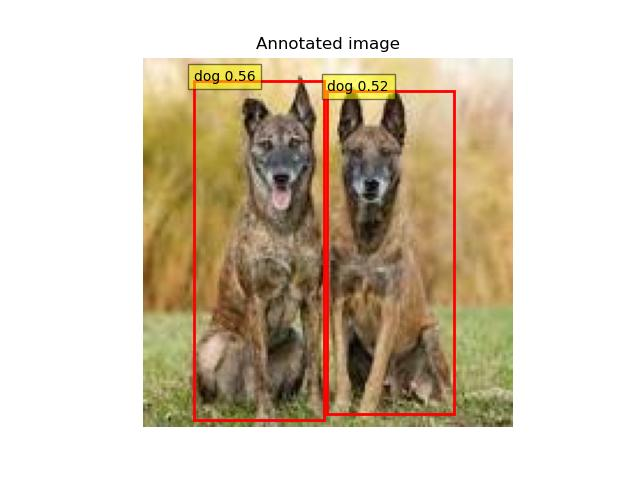

In [5]:
from IPython.display import Image
Image(filename='catdogs_dataset/bboxes_visualization/bbox_5.jpg') 

### 💾 LuxonisDataset

Thanks to the `DataDreamer`, our dataset is already in the correct format: `LuxonisDataset`.

To verify that the data is correctly loaded and split into subsets we can check the dataset's information and visualizations of the annotations.

In [6]:
!luxonis_ml data info cat_dogs_dataset

╭────────── Dataset Info ──────────╮
│ Name: cat_dogs_dataset           │
│                                  │
│ ╭─ Split Sizes ─╮                │
│ │ train: 56     │                │
│ │ val: 12       │                │
│ │ test: 12      │                │
│ │ ───────────── │                │
│ │ Total: 80     │                │
│ ╰───────────────╯                │
│             Classes              │
│ ╭────────────────┬─────────────╮ │
│ │ Task           │ Class Names │ │
│ ├────────────────┼─────────────┤ │
│ │ classification │ dog, cat    │ │
│ │ boundingbox    │ dog, cat    │ │
│ ╰────────────────┴─────────────╯ │
╰──────────────────────────────────╯


In [61]:
!luxonis_ml data inspect cat_dogs_dataset # NOTE: If you are on Google Colab this command will not work

## 🏋️‍♂️ Training

### ⚙️ Configuration

We have prepared the dataset, and we are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task and then edit you to fit your needs.

In our case we are training an object detection and thus we'll take a [`detection_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/detection_light_model.yaml) as a starting point. There are a lot of parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

#### Model
In this section, you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a completely custom neural network by connection different nodes, losses, metrics, and visualizers together. We'll go with the predefined `DetectionModel`.

#### Loader
This section of the config referes to the data loading. You can either set up your custom Loader or use the default one with the LuxonisDataset. In our case, we'll go with the second option, and all we need to do is to set `dataset_name` to `cat_dogs_dataset`

#### Trainer
In this section, we can set up everything connected to actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers and many more. Please refer to the [full documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

**Augmentations**
In our case, we'll leave most of the things as they are; the only change will be adding some augmentations. We use [`Albumentations`](https://albumentations.ai/) for our augmentations with the addition of some custom ones like Mosaic4 and MixUp. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your specific training run. We can add some Affine transforms; for this specific training run, we'll add some Affine transforms, HorizontalFlip, and ColorJitter, but feel free to edit this.

**Callbacks**
Callbacks are very helpful when we want to merge more functionalities into a single training run. For example, we want first to train the model then evaluate it on test subset, export it and create an archive. All of these steps can be defined through the config and done by a single call. For the purpose of a nicer explanation we won't be using them in this tutorial but feel free to set them up on your own. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks)

Below is a starting point for your config. As mentioned we already made some changes to it so it works with this tutorial (change of model name, dataset name and addition of augmentations) but feel free to edit it further and make it your own. When you are done editing you can just execute the cell and the file will be written and ready to use.

**Note**: In case you don't have enough compute on your machine you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled) or you can try lowering number of epochs and/or batch size but in that case performance might drop.

In [ ]:
%%writefile cat_dog_detection_config.yaml
model:
  name: cat_dog_detection_model
  predefined_model:
    name: DetectionModel
    params:
      variant: light

loader:
  params:
    dataset_name: cat_dogs_dataset

trainer:
  preprocessing:
    train_image_size: [160, 160]
    keep_aspect_ratio: true
    normalize:
      active: true

    augmentations:
      - name: Affine
        params:
          scale: [0.7, 1.7]
          rotate: 20
          shear: 5
          p: 0.3
      - name: HorizontalFlip
        params:
          p: 0.3
      - name: ColorJitter
        params:
          brightness: [0.8, 1.2]
          contrast: [0.8, 1.2]
          saturation: [0.8, 1.2]
          hue: 0
          p: 0.2

  batch_size: 8
  epochs: &epochs 200
  n_workers: 8
  validation_interval: 10
  n_log_images: 8

  optimizer:
    name: SGD
    params:
      lr: 0.05
      momentum: 0.937
      weight_decay: 0.0005
      dampening: 0.0
      nesterov: true

  scheduler:
    name: CosineAnnealingLR
    params:
      T_max: *epochs
      eta_min: 0.0002
      last_epoch: -1

Overwriting cat_dog_detection_config.yaml


### 🦾 Train

To start the training we just need to initialize the `LuxonisModel`, pass it the path to the configuration file and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes but when you do it yourself feel free to use them.

In [8]:
from luxonis_train import LuxonisModel

config_path = "cat_dog_detection_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

INFO     GPU available: True (cuda), used: True                                                     ]8;id=714844;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=374835;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=457782;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=346461;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=408889;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=619122;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     Train loader - splits: ['train'], size: 56                                                     ]8;id=681385;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=268993;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#156\156]8;;\

INFO     Val loader - splits: ['val'], size: 12                                                         ]8;id=52299;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=255015;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#156\156]8;;\

INFO     Test loader - splits: ['test'], size: 12                                                       ]8;id=199636;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=680588;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#156\156]8;;\

INFO     Checkpoints will be saved in: output/19-rose-vulture                                           ]8;id=693679;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=706512;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#257\257]8;;\

INFO     Starting training...                                                                           ]8;id=382084;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=374318;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#258\258]8;;\

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=880843;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=574662;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

INFO     You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, ]8;id=730974;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=596826;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will                         
         trade-off precision for performance. For more details, read                                               
         https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se                
         t_float32_matmul_precision                                                                                

2024-11-03 20:16:09.094920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 20:16:09.140449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 20:16:09.140486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 20:16:09.142042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 20:16:09.151234: I tensorflow/core/platform/cpu_feature_guar

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                       ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nodes                      │ ModuleDict        │  4.7 M │ train │
│ 1 │ nodes.detection_backbone   │ EfficientRep      │  3.1 M │ train │
│ 2 │ nodes.detection_neck       │ RepPANNeck        │  1.2 M │ train │
│ 3 │ nodes.detection_head       │ EfficientBBoxHead │  411 K │ train │
│ 4 │ losses                     │ ModuleDict        │  411 K │ train │
│ 5 │ losses.detection_head      │ ModuleDict        │  411 K │ train │
│ 6 │ metrics                    │ ModuleDict        │  411 K │ train │
│ 7 │ metrics.detection_head     │ ModuleDict        │  411 K │ train │
│ 8 │ visualizers                │ ModuleDict        │  411 K │ train │
│ 9 │ visualizers.detection_head │ ModuleDict        │  411 K │ train │
└───┴────────────────────────────┴───────────────────┴────────┴───────┘

Trainable params: 4.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 537                                                                                         
Modules in eval mode: 0

Output()

INFO     Switching to Task Aligned Assigner after 0 warmup epochs.                   ]8;id=948677;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/attached_modules/losses/adaptive_detection_loss.py\adaptive_detection_loss.py]8;;\:]8;id=552498;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/attached_modules/losses/adaptive_detection_loss.py#209\209]8;;\

WARNING  /opt/conda/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes        ]8;id=614067;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=807668;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#121\121]8;;\
         doesn't contain any box. No box was drawn                                                                 
           warnings.warn("boxes doesn't contain any box. No box was drawn")                                        
                                                                                                                   

INFO     Computing metrics on val subset ...                                               ]8;id=715902;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=158795;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=344036;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=769006;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 3.0586                                                           ]8;id=286456;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=762101;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 3.0586304664611816

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.00000  │
│ map_50        │ 0.00000  │
│ map_75        │ 0.00000  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.00000  │
│ mar_1         │ 0.00000  │
│ mar_10        │ 0.00000  │
│ mar_100       │ 0.00000  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.00000  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ nan      │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.0000                     ]8;id=123128;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=685424;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

WARNING  /opt/conda/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number ]8;id=68527;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=177593;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#121\121]8;;\
         of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50).               
         Set a lower value for log_every_n_steps if you want to see logs for the training epoch.                   
                                                                                                                   

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=862690;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=992723;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=497674;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=952524;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.5043                                                           ]8;id=715902;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=158795;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.5042516589164734

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.21017  │
│ map_50        │ 0.28893  │
│ map_75        │ 0.21962  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.36517  │
│ mar_1         │ 0.24464  │
│ mar_10        │ 0.24464  │
│ mar_100       │ 0.24464  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.50714  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.42460  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2102                     ]8;id=885422;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=344036;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=574271;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=311095;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=882769;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=875343;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3775                                                           ]8;id=926471;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=437997;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3775282502174377

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.27108  │
│ map_50        │ 0.43495  │
│ map_75        │ 0.23267  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.03366  │
│ map_large     │ 0.32806  │
│ mar_1         │ 0.40982  │
│ mar_10        │ 0.40982  │
│ mar_100       │ 0.40982  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.03333  │
│ mar_large     │ 0.60357  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.03350  │
│ f1_large      │ 0.42507  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2711                     ]8;id=835089;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=732534;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=547765;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=362240;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=917227;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=168392;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4616                                                           ]8;id=782066;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=387584;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4615551233291626

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.19975  │
│ map_50        │ 0.27764  │
│ map_75        │ 0.23432  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.27715  │
│ mar_1         │ 0.34554  │
│ mar_10        │ 0.34554  │
│ mar_100       │ 0.34554  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.58929  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.37699  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1998                     ]8;id=363845;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=292507;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=336216;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=387155;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=484278;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=127576;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4003                                                           ]8;id=512677;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=626733;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4003124833106995

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.24122  │
│ map_50        │ 0.27503  │
│ map_75        │ 0.27503  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.30954  │
│ mar_1         │ 0.33839  │
│ mar_10        │ 0.33839  │
│ mar_100       │ 0.33839  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.58214  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.40417  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2412                     ]8;id=451141;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=151839;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=718942;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=537760;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=830983;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=782343;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4191                                                           ]8;id=357849;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=4150;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4190561771392822

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.33193  │
│ map_50        │ 0.45792  │
│ map_75        │ 0.29059  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.38762  │
│ mar_1         │ 0.40357  │
│ mar_10        │ 0.40357  │
│ mar_100       │ 0.40357  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.62857  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.47953  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3319                     ]8;id=991613;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=15803;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=214635;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=717219;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=553496;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=143952;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3787                                                           ]8;id=256730;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=985282;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.378732442855835

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.28002  │
│ map_50        │ 0.35252  │
│ map_75        │ 0.31093  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.34151  │
│ mar_1         │ 0.42411  │
│ mar_10        │ 0.42411  │
│ mar_100       │ 0.42411  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.66786  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.45193  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2800                     ]8;id=132273;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=13773;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=219915;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=423865;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=800518;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=655233;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4874                                                           ]8;id=755191;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=700449;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4874083995819092

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.17879  │
│ map_50        │ 0.23479  │
│ map_75        │ 0.16851  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.26292  │
│ mar_1         │ 0.38839  │
│ mar_10        │ 0.38839  │
│ mar_100       │ 0.38839  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.63214  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.37138  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1788                     ]8;id=459535;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=1909;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=473418;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=430469;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=478064;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=657888;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3627                                                           ]8;id=735215;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=492259;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3626983165740967

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.28333  │
│ map_50        │ 0.36762  │
│ map_75        │ 0.31014  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.11782  │
│ map_large     │ 0.32528  │
│ mar_1         │ 0.40982  │
│ mar_10        │ 0.44107  │
│ mar_100       │ 0.44107  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.11667  │
│ mar_large     │ 0.60357  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.11724  │
│ f1_large      │ 0.42273  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2833                     ]8;id=714059;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=139509;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=748709;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=322766;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=375113;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=430981;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4873                                                           ]8;id=621801;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=272230;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4873000979423523

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.17195  │
│ map_50        │ 0.21664  │
│ map_75        │ 0.17420  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.25937  │
│ mar_1         │ 0.28036  │
│ mar_10        │ 0.32411  │
│ mar_100       │ 0.32411  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.56786  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.35610  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1719                     ]8;id=803631;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=28898;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=347538;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=340272;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=730226;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=11636;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4934                                                           ]8;id=789395;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=924402;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4934165477752686

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.17509  │
│ map_50        │ 0.27008  │
│ map_75        │ 0.17079  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.30831  │
│ mar_1         │ 0.29018  │
│ mar_10        │ 0.29018  │
│ mar_100       │ 0.29018  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.49643  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.38038  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1751                     ]8;id=965713;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=360257;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=31895;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=991952;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=73679;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=291842;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.5864                                                           ]8;id=154959;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=301553;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.5863916873931885

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.12959  │
│ map_50        │ 0.17360  │
│ map_75        │ 0.13647  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.18849  │
│ mar_1         │ 0.25893  │
│ mar_10        │ 0.30268  │
│ mar_100       │ 0.30268  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.54643  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.28029  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1296                     ]8;id=870912;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=200884;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=277922;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=756601;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=382807;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=9651;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.6044                                                           ]8;id=443423;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=421146;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.6043875217437744

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.12512  │
│ map_50        │ 0.17673  │
│ map_75        │ 0.08894  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00337  │
│ map_large     │ 0.15092  │
│ mar_1         │ 0.21607  │
│ mar_10        │ 0.29375  │
│ mar_100       │ 0.29375  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.01667  │
│ mar_large     │ 0.40000  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.00560  │
│ f1_large      │ 0.21916  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1251                     ]8;id=358527;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=362027;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=823421;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=543716;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=534212;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=905909;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4445                                                           ]8;id=483176;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=262986;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4444674849510193

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.23591  │
│ map_50        │ 0.31023  │
│ map_75        │ 0.25248  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.08416  │
│ map_large     │ 0.30154  │
│ mar_1         │ 0.25804  │
│ mar_10        │ 0.34554  │
│ mar_100       │ 0.34554  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.15000  │
│ mar_large     │ 0.51429  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.10782  │
│ f1_large      │ 0.38017  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2359                     ]8;id=300174;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=797440;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=64597;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=501011;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=374442;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=89647;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3866                                                           ]8;id=635652;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=13669;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3866226077079773

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.30677  │
│ map_50        │ 0.39113  │
│ map_75        │ 0.32294  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.43885  │
│ mar_1         │ 0.40179  │
│ mar_10        │ 0.44554  │
│ mar_100       │ 0.44554  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.68929  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.53627  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3068                     ]8;id=179551;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=663550;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=699226;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=163645;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=414730;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=982454;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.4156                                                           ]8;id=375724;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=186902;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4156389236450195

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.22792  │
│ map_50        │ 0.30767  │
│ map_75        │ 0.20289  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.03871  │
│ map_large     │ 0.25998  │
│ mar_1         │ 0.28036  │
│ mar_10        │ 0.34911  │
│ mar_100       │ 0.34911  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.13333  │
│ mar_large     │ 0.46786  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.06000  │
│ f1_large      │ 0.33424  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2279                     ]8;id=558353;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=254608;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=779801;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=53014;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=691263;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=885944;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3995                                                           ]8;id=505486;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=337319;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.399507224559784

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.31058  │
│ map_50        │ 0.43485  │
│ map_75        │ 0.30693  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.06452  │
│ map_large     │ 0.42676  │
│ mar_1         │ 0.39464  │
│ mar_10        │ 0.43214  │
│ mar_100       │ 0.43214  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.15000  │
│ mar_large     │ 0.58214  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.09023  │
│ f1_large      │ 0.49248  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3106                     ]8;id=137221;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=412409;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=670362;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=123630;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=615226;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=809198;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3748                                                           ]8;id=618892;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=795965;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3748390078544617

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.24692  │
│ map_50        │ 0.33543  │
│ map_75        │ 0.22640  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.04208  │
│ map_large     │ 0.36904  │
│ mar_1         │ 0.20893  │
│ mar_10        │ 0.34286  │
│ mar_100       │ 0.34286  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.08333  │
│ mar_large     │ 0.51786  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.05592  │
│ f1_large      │ 0.43096  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2469                     ]8;id=169795;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=229994;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=363820;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=549117;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=329470;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=976134;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3451                                                           ]8;id=30557;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=941051;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3450707793235779

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.27703  │
│ map_50        │ 0.39317  │
│ map_75        │ 0.23451  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.12343  │
│ map_large     │ 0.31590  │
│ mar_1         │ 0.29911  │
│ mar_10        │ 0.44554  │
│ mar_100       │ 0.44554  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.16667  │
│ mar_large     │ 0.58929  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.14183  │
│ f1_large      │ 0.41131  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2770                     ]8;id=757948;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=91798;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=269880;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=466600;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=524898;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=224622;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3927                                                           ]8;id=849210;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=164567;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.39266836643219

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.30507  │
│ map_50        │ 0.40686  │
│ map_75        │ 0.28761  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.09257  │
│ map_large     │ 0.36581  │
│ mar_1         │ 0.41339  │
│ mar_10        │ 0.48214  │
│ mar_100       │ 0.48214  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.15000  │
│ mar_large     │ 0.63214  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.11449  │
│ f1_large      │ 0.46344  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3051                     ]8;id=529186;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=308909;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=472291;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=839753;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=803178;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=842731;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Validation loss: 1.3497                                                           ]8;id=55667;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=440573;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.3496578335762024

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.31376  │
│ map_50        │ 0.41700  │
│ map_75        │ 0.29521  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.10941  │
│ map_large     │ 0.42940  │
│ mar_1         │ 0.37054  │
│ mar_10        │ 0.43929  │
│ mar_100       │ 0.43929  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.15000  │
│ mar_large     │ 0.58929  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.12653  │
│ f1_large      │ 0.49679  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3138                     ]8;id=889523;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=80749;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

INFO     `Trainer.fit` stopped: `max_epochs=200` reached.                                           ]8;id=487769;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=176584;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     Training finished                                                                              ]8;id=228089;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=280941;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#265\265]8;;\

INFO     Checkpoints saved in: output/19-rose-vulture                                                   ]8;id=25466;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=170663;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#266\266]8;;\

`LuxonisTrain` already implements automatic tracking of our training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory in it, and each run also has its own training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [9]:
RUN_NAME = "output/19-rose-vulture"

In [10]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

## ✍ Test

Now we have a model that we are happy with, that seems to perform well on the validation set. The next step is to check its performance on the testing set. This is a collection of images that we've kept hidden from the model so far and should be only used to objectively evaluate if the model is good or not. Since this is an object detection task we use mean average precision metric to quantitatively check the model performance.

If you check out ran directory you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both of these have checkpoint files that were generated during trainig based on best validation metric performance and minimal validation loss respectively. For evaluation we'll want to use one of these checkpoints, we recommend you use one that has lowest validation loss.

In [11]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

INFO     Loaded checkpoint from                                                            ]8;id=884196;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=531792;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\
         /home/jovyan/output/19-rose-vulture/min_val_loss/cat_dog_detection_model_loss=1.3                         
         451_179.ckpt.                                                                                             

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=276373;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=59018;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO     Computing metrics on test subset ...                                              ]8;id=939583;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=942924;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#732\732]8;;\

INFO     Metrics computed.                                                                 ]8;id=97834;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=738912;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#734\734]8;;\

INFO     Test loss: 1.4114                                                                 ]8;id=148665;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=15996;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#915\915]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 1.4114233255386353

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.30728  │
│ map_50        │ 0.50219  │
│ map_75        │ 0.27153  │
│ map_small     │ -1.00000 │
│ map_medium    │ -1.00000 │
│ map_large     │ 0.32917  │
│ mar_1         │ 0.34167  │
│ mar_10        │ 0.42500  │
│ mar_100       │ 0.42500  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ -1.00000 │
│ mar_large     │ 0.42500  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ -1.00000 │
│ f1_large      │ 0.37099  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (detection_head/detection_map): 0.3073                           ]8;id=988047;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=362488;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#924\924]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/loss                   │              1.4114233255386353               │
│    test/loss/detection_head/detection_loss    │              1.4114233255386353               │
│ test/loss/detection_head/detection_loss/class │              0.9030523896217346               │
│  test/loss/detection_head/detection_loss/iou  │              0.20334835350513458              │
│   test/metric/detection_head/detection_map    │              0.30728429555892944              │
│      test/metric/detection_head/f1_large      │              0.3709937036037445               │
│     test/metric/detection_head/f1_medium      │                     -1.0                      │
│      test/metric/detection_head/f1_small      │                     -1.0                      │
│       test/metric/detection_head/map_50       │              0.5021923780441284               │
│       test/metric/detection_head/map_75       │              0.27153465151786804              │
│     test/metric/detection_head/map_large      │              0.3291654884815216               │
│     test/metric/detection_head/map_medium     │                     -1.0                      │
│     test/metric/detection_head/map_small      │                     -1.0                      │
│       test/metric/detection_head/mar_1        │              0.34166666865348816              │
│       test/metric/detection_head/mar_10       │              0.42500001192092896              │
│      test/metric/detection_head/mar_100       │              0.42500001192092896              │
│     test/metric/detection_head/mar_large      │              0.42500001192092896              │
│     test/metric/detection_head/mar_medium     │                     -1.0                      │
│     test/metric/detection_head/mar_small      │                     -1.0                      │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

### 🧠 Infer

Usually, we also want to check the qualitative performance of our model, i.e., how well it visually predicts on the test images. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer or test images.

In [12]:
luxonis_model.infer(
    weights=weights,
    view="test"
)

# NOTE: If you are using Google Colab use this and images will be saved to "infer_results" directory
# luxonis_model.infer(weights=weights, save_dir="infer_results") 

INFO     Loaded checkpoint from                                                            ]8;id=54625;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=28220;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\
         /home/jovyan/output/19-rose-vulture/min_val_loss/cat_dog_detection_model_loss=1.3                         
         451_179.ckpt.                                                                                             

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 luxonis_model.infer(                                                                         │
│   2 │   weights=weights,                                                                         │
│   3 │   view="test"                                                                              │
│   4 )                                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py:493 in infer                  │
│                                                                                                  │
│   490 │   │   │   │   │   │   f"Source path {source_path} is not a valid file or directory."     │
│   491 │   │   │   │   │   )                                                                      │
│   492 │   │   │   else:                                                                          │
│ ❱ 493 │   │   │   │   infer_from_dataset(self, view, save_dir)                                   │
│   494 │                                                                                          │
│   495 │   def tune(self) -> None:                                                                │
│   496 │   │   """Runs Optuna tuning of hyperparameters."""                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/infer_utils.py:183 in           │
│ infer_from_dataset                                                                               │
│                                                                                                  │
│   180 │   │                                                                                      │
│   181 │   │   images = get_denormalized_images(model.cfg, inputs)                                │
│   182 │   │   batch_size = images.shape[0]                                                       │
│ ❱ 183 │   │   outputs = model.lightning_module.forward(                                          │
│   184 │   │   │   inputs, labels, images=images, compute_visualizations=True                     │
│   185 │   │   )                                                                                  │
│   186 │   │   renders = process_visualizations(                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py:404 in forward │
│                                                                                                  │
│   401 │   │   │   │   and labels is not None                                                     │
│   402 │   │   │   ):                                                                             │
│   403 │   │   │   │   for loss_name, loss in self.losses[node_name].items():                     │
│ ❱ 404 │   │   │   │   │   losses[node_name][loss_name] = loss.run(outputs, labels)               │
│   405 │   │   │                                                                                  │
│   406 │   │   │   if (                                                                           │
│   407 │   │   │   │   compute_metrics                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/luxonis_train/attac

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model that was trained with PyTorch to a more general format called ONNX. Then, we want to package this exported model with all the metadata that holds information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be easily done by just one command in LuxonisTrain.

In [13]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

INFO     Loaded checkpoint from                                                            ]8;id=766542;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=38974;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\
         /home/jovyan/output/19-rose-vulture/min_val_loss/cat_dog_detection_model_loss=1.3                         
         451_179.ckpt.                                                                                             

WARNING  No model executable specified for archiving.                                                   ]8;id=494496;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=815865;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#689\689]8;;\

INFO     Exporting model to ONNX...                                                                     ]8;id=322414;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=27766;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#691\691]8;;\

WARNING  No model weights specified. Exporting model without weights.                                   ]8;id=119409;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=395662;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#310\310]8;;\

INFO     Reparametrizing 'EfficientRep'.                                                        ]8;id=523399;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/backbones/efficientrep/efficientrep.py\efficientrep.py]8;;\:]8;id=975794;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/backbones/efficientrep/efficientrep.py#134\134]8;;\

INFO     Reparametrizing 'RepPANNeck'.                                                           ]8;id=26328;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/necks/reppan_neck/reppan_neck.py\reppan_neck.py]8;;\:]8;id=170901;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/necks/reppan_neck/reppan_neck.py#191\191]8;;\

INFO     Model exported to output/19-rose-vulture/export/cat_dog_detection_model.onnx      ]8;id=847442;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=702212;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#575\575]8;;\

INFO     Simplifying ONNX model...                                                               ]8;id=960300;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=225329;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#41\41]8;;\

INFO     ONNX model saved to output/19-rose-vulture/export/cat_dog_detection_model.onnx          ]8;id=489210;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=64761;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#47\47]8;;\

INFO     NN Archive saved to output/19-rose-vulture/archive/cat_dog_detection_model.onnx.tar.xz         ]8;id=71438;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=996688;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#765\765]8;;\

ERROR    Failed to strictly load old weights. The model likely underwent re-parametrization,     ]8;id=495647;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=269725;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#27\27]8;;\
         which is a destructive operation. Loading old weights with strict=False.                                  

Model archieved to: output/19-rose-vulture/archive/cat_dog_detection_model.onnx.tar.xz


Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file which holds aforementioned ONNX model with all the metadata of the model.

## 🤖 Deploy

We have the exported model, and the goal is to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. To simplify the process, we recommend you use our [`HubAI`](https://hub.luxonis.com) platform. You can log in, navigate to the AI section, and click the `+ Add Model` button. 

<img src="./media/first_page.png" alt="first page" width="800">

Once there, you'll want to click `Custom,` and then fill out the form to provide some description of your model. At the bottom, you can upload the actual model files. Since we have already generated an `NNArchive` (our .tar.xz file), please add it here by clicking `Add`. 

<img src="./media/model_description.png" alt="model description" width="400">

Once the model is uploaded, you will see it under `Team's Models`, and when you click it, you can export it for your specific Luxonis device version. 

<img src="./media/convert.png" alt="convert" width="800">

The process might take some time; after it's finished, we can download and use the model with our DepthAI script. We'll use RVC2 in this tutorial, but you can follow the same process for other versions. All that is left to do is create a DepthAI script and deploy the model to the device. We already made such an example below. You need to populate two variables, though:
- `ModelSlug`: This is a string representation of your model version based on which DepthAI can download it. You can get it by clicking the `Copy Slug` button next to the `Convert` you used before.
- `ApiToken`: Since this model is private to your team, you need a token to access it. To generate the token, we navigate to team settings and click `+ Create API Token`. We then copy and paste it into the script below. 

<img src="./media/model_slug.png" alt="model_slug" width="400">

<img src="./media/api_token.png" alt="api_token" width="400">

### 📷 DepthAI Script

In [14]:
MODEL_SLUG = "fruit-detection-model:model-version-1" # TODO: Insert your model slug
API_TOKEN = "insert_your_token_here" # TODO: Insert your API Token
API_TOKEN = "tapi.o0M6yGp4pI_JSUKjdBTzKg.WOaw2jbrgPcHkX4GZfbn0pElq9wQNqUzvxmjjeHhfMjOfFrW-6XqP0sVGL58iLlNGJY9OTsBFuWKziXfcYOEDw" 

To run the DepthAI script we need to install it. Also note that this script must be run locally and needs a Luxonis device connected to your machine. 

In [15]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a4

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 26.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from typing import Tuple
import depthai as dai
import os

os.environ["DEPTHAI_TOKEN"] = API_TOKEN

def parse_model_slug(full_slug) -> Tuple[str, str]:
    if ":" not in full_slug:
        raise NameError(
            "Please provide the model slug in the format of 'model_slug:model_version_slug'"
        )
    model_slug_parts = full_slug.split(":")
    model_slug = model_slug_parts[0]
    model_version_slug = model_slug_parts[1]

    return model_slug, model_version_slug

labels = ["cat", "dog"]

with dai.Pipeline() as pipeline:
    camera_node = pipeline.create(dai.node.Camera).build()

    model_slug, model_version_slug = parse_model_slug(MODEL_SLUG)
    model = dai.NNModelDescription(
        modelSlug=model_slug, modelVersionSlug=model_version_slug
    )

    detection_nn = pipeline.create(dai.node.DetectionNetwork).build(camera_node, model)

    frame_queue = detection_nn.passthrough.createOutputQueue()
    detection_queue = detection_nn.out.createOutputQueue()

    pipeline.start()

    while pipeline.isRunning():
        frame: np.ndarray = frame_queue.get().getCvFrame()
        nn_output: dai.ImgDetections = detection_queue.get()

        for detection in nn_output.detections:
            xmin, ymin, xmax, ymax = (
                detection.xmin,
                detection.ymin,
                detection.xmax,
                detection.ymax,
            )

            xmin = int(xmin * frame.shape[1])
            ymin = int(ymin * frame.shape[0])
            xmax = int(xmax * frame.shape[1])
            ymax = int(ymax * frame.shape[0])

            cv2.rectangle(
                frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2
            )
            cv2.putText(
                frame,
                f"{detection.confidence * 100:.2f}%",
                (int(xmin) + 10, int(ymin) + 20),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )
            cv2.putText(
                frame,
                labels[detection.label],
                (int(xmin) + 10, int(ymin) + 40),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )

        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)
        if key == ord("q"):
            pipeline.stop()
            break

[2024-11-03 20:25:25.401] [depthai] [warning] USB protocol not available - If running in a container, make sure that the following is set: "-v /dev/bus/usb:/dev/bus/usb --device-cgroup-rule='c 189:* rmw'"


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17                                                                                             │
│   18 labels = ["cat", "dog"]                                                                     │
│   19                                                                                             │
│ ❱ 20 with dai.Pipeline() as pipeline:                                                            │
│   21 │   camera_node = pipeline.create(dai.node.Camera).build()                                  │
│   22 │                                                                                           │
│   23 │   model_slug, model_version_slug = parse_model_slug(MODEL_SLUG)                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: No available devices